In [23]:
import volrpynn.nest as v
import numpy as np
import pyNN.nest as pynn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
parameters = {"tau_syn_I":5,"tau_refrac":0,"v_thresh":-50,"v_rest":-65,"tau_syn_E":5,"v_reset":-65,"tau_m":20,"e_rev_I":-70,"i_offset":0,"cm":1,"e_rev_E":0}

In [25]:
pynn.setup()
p1 = pynn.Population(1, pynn.IF_cond_exp(**parameters))
p1.record(['spikes', 'v'])

In [26]:
def simulate(offset):
    for recorder in pynn.simulator.state.recorders:
        recorder.clear()
    pynn.reset()
    p1.set(i_offset=offset)
    pynn.run(50)
    return p1.get_data()

def membrane_simulate(offset, pop):
    simulate(offset)
    b = pop.get_data()
    return b.segments[0].filter(name='v')[0]
    
def plot_membrane_simulate(offset, pop):
    current = membrane_simulate(offset, pop)
    spikes = len(pop.get_data().segments[0].spiketrains[0])
    plt.gca().set_title('Spikes: ' + str(spikes))
    plt.plot(np.arange(0, 50.1, 0.1), current)
    
def spikes_simulate(offset, pop):
    simulate(offset)
    b = pop.get_data()
    return len(b.segments[0].spiketrains[0])

## Membrane current plot

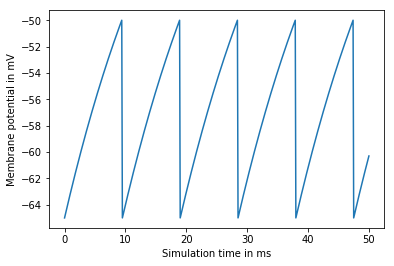

In [5]:
plot_membrane_simulate(2, p1)
plt.gca().set_title('')
plt.gcf().set_size_inches(6, 4)
plt.gca().set_xlabel('Simulation time in ms')
plt.gca().set_ylabel('Membrane potential in mV')
plt.savefig('membrane.svg')

## Spike rate plot

In [12]:
xs = np.arange(0, 12.6, 0.1)
spikes = [spikes_simulate(x, p1) for x in xs]

In [7]:
reg = LinearRegression().fit(xs.reshape(-1, 1), spikes)
print(reg.coef_, reg.intercept_)
pred_y = reg.predict(xs.reshape(-1, 1))
r2_score(spikes, pred_y)

[ 3.20632009] -1.45822956758


0.9980290812276188

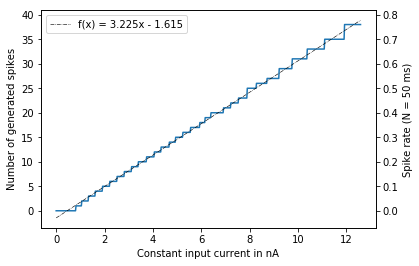

In [8]:
plt.gca().plot(xs, spikes)
plt.gca().set_ylabel('Number of generated spikes')
plt.gca().set_xlabel('Constant input current in nA')
plt.gca().set_title('')
plt.gcf().set_size_inches(6, 4)
plt.plot(xs, pred_y, color='black', linewidth=0.6, label="f(x) = 3.225x - 1.615", linestyle="-.")
plt.legend()
ylim1, ylim2 = plt.gca().get_ylim()
ax2 = plt.gca().twinx()
ax2.set_ylim(ylim1 / 50, ylim2 / 50)
ax2.set_ylabel('Spike rate (N = 50 ms)')
plt.savefig('spike_rate.svg')

## Deeper layers

In [27]:
p2 = pynn.Population(1, pynn.IF_cond_exp(**parameters))
proj2 = pynn.Projection(p1, p2, pynn.AllToAllConnector())
p3 = pynn.Population(1, pynn.IF_cond_exp(**parameters))
proj3 = pynn.Projection(p2, p3, pynn.AllToAllConnector())
p4 = pynn.Population(1, pynn.IF_cond_exp(**parameters))
proj4 = pynn.Projection(p3, p4, pynn.AllToAllConnector())
p2.record(['v', 'spikes'])
p3.record(['v', 'spikes'])
p4.record(['v', 'spikes'])

In [28]:
def spikes_simulate_deep(offset, weight_function):
    proj2.set(weight=weight_function(offset, p1.size, p2.size))
    proj3.set(weight=weight_function(offset, p2.size, p3.size))
    proj4.set(weight=weight_function(offset, p3.size, p4.size))
    simulate(offset)
    return (p1.get_data(), p2.get_data(), p3.get_data(), p4.get_data())

def to_spikes(d):
    return d.segments[0].spiketrains[0].size

def to_potential(d):
    return d.filter('v')

## Spike rates with constant weights

In [13]:
data_constant = [spikes_simulate_deep(x, lambda r, pop_in, pop_out: 1) for x in xs]

In [14]:
spikes_constant = np.array([(to_spikes(x[0]), to_spikes(x[1]), to_spikes(x[2]), to_spikes(x[3])) for x in data_constant])

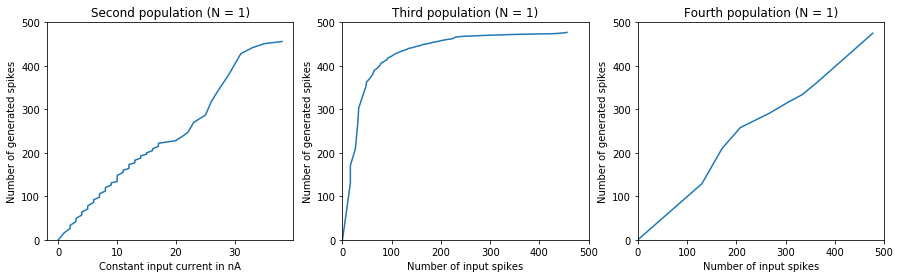

In [22]:
plt.figure(figsize=(15, 4))
ax = plt.subplot(131)
ax.set_ylim(0, 500)
ax.set_title('Second population (N = 1)')
plt.ylabel('Number of generated spikes')
plt.xlabel('Constant input current in nA')
plt.plot(spikes_constant[:, 0], spikes_constant[:, 1])
ax2 = plt.subplot(132)
ax2.set_ylim(0, 500)
ax2.set_xlim(0, 500)
ax2.set_title('Third population (N = 1)')
plt.ylabel('Number of generated spikes')
plt.xlabel('Number of input spikes')
plt.plot(spikes_constant[:, 1], spikes_constant[:, 2])
ax3 = plt.subplot(133)
ax3.set_ylim(0, 500)
ax3.set_xlim(0, 500)
ax3.set_title('Fourth population (N = 1)')
plt.ylabel('Number of generated spikes')
plt.xlabel('Number of input spikes')
plt.plot(spikes_constant[:, 2], spikes_constant[:, 3])
plt.savefig('spike_rate_not_weighted.svg')

## Spike rates with adjusted weights

In [16]:
data = [spikes_simulate_deep(x, lambda r, pop_in, pop_out: 0.065 / pop_in) for x in xs]

In [17]:
spikes = np.array([(to_spikes(x[0]), to_spikes(x[1]), to_spikes(x[2]), to_spikes(x[3])) for x in data])

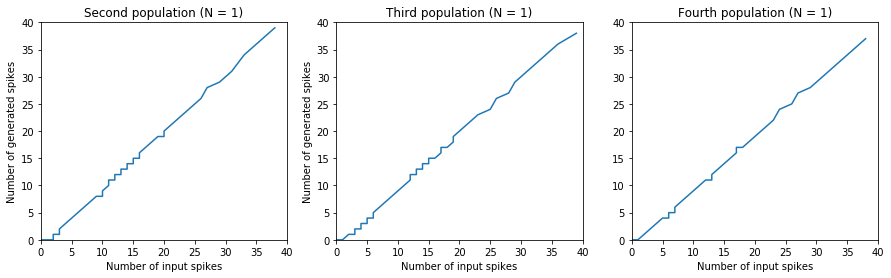

In [20]:
plt.figure(figsize=(15, 4))
ax = plt.subplot(131)
ax.set_ylim(0, 40)
ax.set_xlim(0, 40)
ax.set_title('Second population (N = 1)')
plt.ylabel('Number of generated spikes')
plt.xlabel('Number of input spikes')
plt.plot(spikes[:, 0], spikes[:, 1])
ax2 = plt.subplot(132)
ax2.set_ylim(0, 40)
ax2.set_xlim(0, 40)
ax2.set_title('Third population (N = 1)')
plt.ylabel('Number of generated spikes')
plt.xlabel('Number of input spikes')
plt.plot(spikes[:, 1], spikes[:, 2])
ax3 = plt.subplot(133)
ax3.set_ylim(0, 40)
ax3.set_xlim(0, 40)
ax3.set_title('Fourth population (N = 1)')
plt.xlabel('Number of input spikes')
plt.plot(spikes[:, 2], spikes[:, 3])
plt.savefig('spike_rate_chain.svg')

In [33]:
data = [spikes_simulate_deep(x, lambda r, pop_in, pop_out: 0.5 * (0.065 / pop_in)) for x in xs]
spikes = np.array([(to_spikes(x[0]), to_spikes(x[1]), to_spikes(x[2]), to_spikes(x[3])) for x in data])

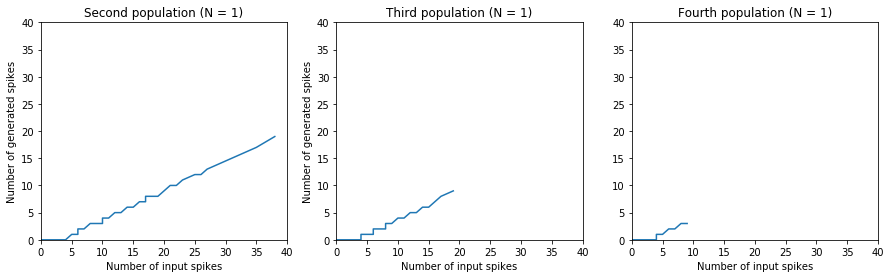

In [34]:
plt.figure(figsize=(15, 4))
ax = plt.subplot(131)
ax.set_ylim(0, 40)
ax.set_xlim(0, 40)
ax.set_title('Second population (N = 1)')
plt.ylabel('Number of generated spikes')
plt.xlabel('Number of input spikes')
plt.plot(spikes[:, 0], spikes[:, 1])
ax2 = plt.subplot(132)
ax2.set_ylim(0, 40)
ax2.set_xlim(0, 40)
ax2.set_title('Third population (N = 1)')
plt.ylabel('Number of generated spikes')
plt.xlabel('Number of input spikes')
plt.plot(spikes[:, 1], spikes[:, 2])
ax3 = plt.subplot(133)
ax3.set_ylim(0, 40)
ax3.set_xlim(0, 40)
ax3.set_title('Fourth population (N = 1)')
plt.xlabel('Number of input spikes')
plt.plot(spikes[:, 2], spikes[:, 3])
plt.savefig('spike_rate_chain.svg')